# Imports

This lecture covers using scikit-learn for machine learning purposes. But before we begin, please note that you should *never* import all of scikit-learn at once! Instead, import only what you need, when you need it.

In [1]:
# import sklearn - BAD!!!!!!

Its a similar case with matplotlib, though importing pyplot ahead of time is a good idea. And it's fine to just use all of numpy.

In [1]:
from matplotlib import pyplot as plt
import numpy as np

# Introducing our data!

For testing classifiers, we will be using the **Iris** dataset from scikit-learn.

In [2]:
from sklearn import datasets

# Load dataset
iris = datasets.load_iris()

# Use petal length/width as inputs, species as output
X = iris.data[:, [2,3]]
y = iris.target

# Save full dataset just in case
X_full = iris.data[:, :]
y_full = iris.target

**X** is a list of petal lengths and petal widths for 150 flowers of the *Iris* genus. **y** is an array of integers representing the flowers' species: 0 for *Iris Setosa*, 1 for *Iris Versicolor*, and 2 for *Iris Virginica*. Our goal is to use X to predict y.

Now, let's see how the data looks:

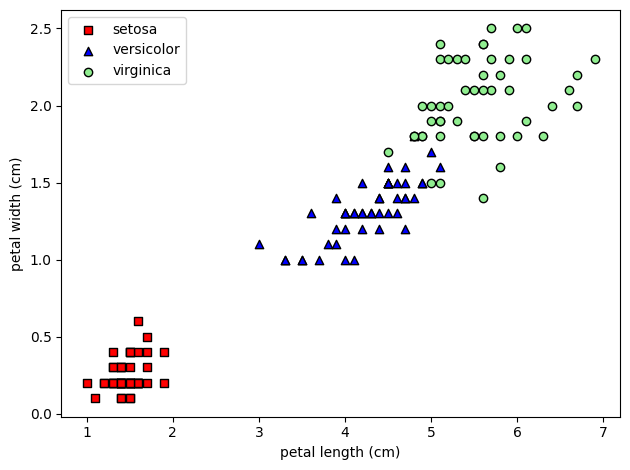

In [3]:
# Plot each species separately
plt.scatter(X[y==0,0],X[y==0,1],color='red',marker='s',label='setosa',edgecolor='black')
plt.scatter(X[y==1,0],X[y==1,1],color='blue',marker='^',label='versicolor',edgecolor='black')
plt.scatter(X[y==2,0],X[y==2,1],color='lightgreen',marker='o',label='virginica',edgecolor='black')

# Prepare graph labels
plt.xlabel('petal length (cm)')
plt.ylabel('petal width (cm)')
plt.legend(loc='upper left')

# Show square graph
plt.tight_layout()
plt.show()

Well, distinguishing the *setosa* species seems easy enough. But what about the other two? These classes are mixed together, so we'll have to use machine learning techniques to separate them as much as possible. Please keep in mind that we only have a small sample of the population!

# Data Preparation (Preprocessing)

Before we begin, let's perform some **preprocessing** on our data. This means that we're going to get it ready to enter our machine learning models. For most models, at least *some* preprocessing is required, and there's lots of more advanced options like PCA. But let's keep things simple for now.

In [4]:
from sklearn.model_selection import train_test_split

# Prepare training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

The first thing we did was randomly split the data into a **training** and **testing** dataset. Because of this, 30% of our data has been marked for testing our model rather than training it. We also **stratified** our data to keep the overall distribution of species constant in both sets.

Next, we're going to **standardize** our data as follows:

In [5]:
from sklearn.preprocessing import StandardScaler

# Prepare scaler
sc = StandardScaler() #does input scaling

# Fit scaler on training data
sc.fit(X_train)
X_train_std = sc.transform(X_train)
# NOTE: you can just use sc.fit_transform to do both these steps at once!

# Update testing data to match
X_test_std = sc.transform(X_test)

We've effectively just calculated the z-scores of the data by subtracting the sample mean from each point and then dividing by the standard deviation. This helps **scale** the data to make training easier, but it does assume that it comes from a normal distribution.

Lastly, for the sake of convenience let's reorganize the original data, then save a combination of the training and testing data.

In [6]:
# Reorganize original data
X = np.vstack((X_train,X_test))
y = np.hstack((y_train,y_test))

# Save standardized data
X_std = np.vstack((X_train_std,X_test_std))

We're now going to repeat these steps on the full, 4D Iris dataset in case we want to test how our models perform with more input features.

In [71]:
# Prepare training and testing datasets
X_full_train, X_full_test, y_full_train, y_full_test = train_test_split(X_full, y_full, test_size=0.3, random_state=1, stratify=y_full)

# Prepare scaler
sc = StandardScaler()

# Fit scaler on training data
X_full_train_std = sc.fit_transform(X_full_train)

# Update testing data to match
X_full_test_std = sc.transform(X_full_test)

# Reorganize original data
X_full = np.vstack((X_full_train,X_full_test))
y_full = np.hstack((y_full_train,y_full_test))

# Save standardized data
X_full_std = np.vstack((X_full_train_std,X_full_test_std))

# Now if you want to call the 4D data, just use X_full instead of X

# Classification

## K Nearest Neighbors

To introduce the concept of machine learning as well as its implementation in scikit-learn, we'll start with the **K-Nearest Neighbors** algorithm. It's better to see it in action before explaining it fully, so let's first create a model, fit it on our data, and print its accuracy.

In [8]:
from sklearn.neighbors import KNeighborsClassifier

# Prepare KNN with k = 5
my_knn = KNeighborsClassifier(n_neighbors=5)

# Fit KNN on standardized training data
my_knn.fit(X_train_std, y_train)

# Print training and testing accuracy
print("Training Accuracy:",my_knn.score(X_train_std, y_train))
print("Testing Accuracy:",my_knn.score(X_test_std, y_test))

Training Accuracy: 0.9714285714285714
Testing Accuracy: 1.0


Whoa, a perfect score in testing! This must be a super advanced machine learning model, right? Well, let's see how it looks when we graph its decision regions. To help with this, I've copied some code from my favorite machine learning textbook (you can find it here: https://www.amazon.com/Python-Machine-Learning-scikit-learn-TensorFlow/dp/1789955750). Much of the rest of the lecture is also based off of examples found in Chapter 3 of the book.

In [9]:
# Taken directly from Python Machine Learning 3rd Edition
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
  markers = ('s','^','o','x','v')
  colors = ('red','blue','lightgreen','gray','cyan')
  cmap = ListedColormap(colors[:len(np.unique(y))])

  x1_min, x1_max = X[:,0].min() - 1, X[:,0].max() + 1
  x2_min, x2_max = X[:,1].min() - 1, X[:,1].max() + 1
  xx1, xx2 = np.meshgrid(np.arange(x1_min,x1_max,resolution),np.arange(x2_min,x2_max,resolution))
  Z = classifier.predict(np.array([xx1.ravel(),xx2.ravel()]).T)
  Z = Z.reshape(xx1.shape)
  plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
  plt.xlim(xx1.min(),xx1.max())
  plt.ylim(xx2.min(),xx2.max())

  for idx, cl in enumerate(np.unique(y)):
    plt.scatter(x=X[y==cl,0],y=X[y==cl,1],alpha=0.8,c=colors[idx],marker=markers[idx],label=cl,edgecolor='black')

  if test_idx:
    X_test, y_test = X[test_idx,:], y[test_idx]
    plt.scatter(X_test[:,0],X_test[:,1],c="none",edgecolor='black',alpha=1.0,linewidth=1,marker='o',s=100,label='test set')

Now let's see it in action:

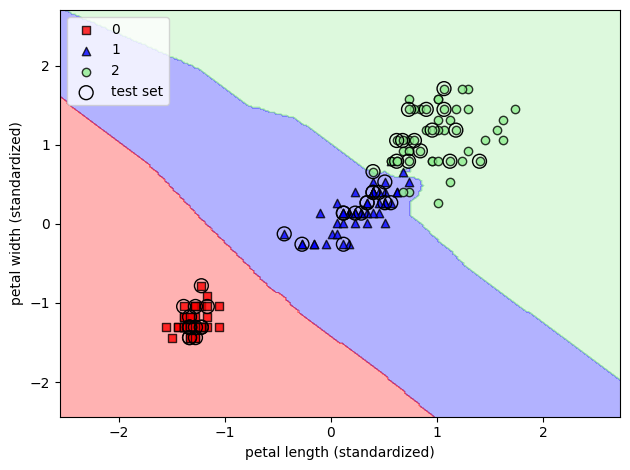

In [10]:
# Use background of graph to represent our predictions
plot_decision_regions(X_std,y,classifier=my_knn,test_idx=range(105,150))

# Label graph
plt.xlabel('petal length (standardized)')
plt.ylabel('petal width (standardized)')
plt.legend(loc='upper left')

# Display graph
plt.tight_layout()
plt.show()

Well, that's a weird result, but that's to be expected with a KNN model!

See, the K-Nearest Neighbors algorithm is infamous for being the "laziest" machine learning model out there. It literally just saves a copy of the training data and then classifies data points by checking the classes of the *k* nearest training points, where *k* is some integer (in this case, 5).

There are several problems in this approach. First, we don't really learn about any large-scale patterns in the dataset, which is why the boundaries between the decision regions look so jagged. Also, if our training dataset is large, then our model will take up a lot of memory.

### Problem 5.6: Where KNNs Go Wrong

**Part 1:** Try training a KNN called my_knn_raw on the non-standardized data and plotting its results. What happens? Do you think the standardization is helpful in this case?

In [14]:
from sklearn.neighbors import KNeighborsClassifier

# Prepare KNN with k = 5
my_knn_raw = KNeighborsClassifier(n_neighbors=5)

# Fit KNN on standardized training data
my_knn_raw.fit(X_train, y_train)

# Print training and testing accuracy
print("Training Accuracy:",my_knn_raw.score(X_train, y_train))
print("Testing Accuracy:",my_knn_raw.score(X_test, y_test))

Training Accuracy: 0.9619047619047619
Testing Accuracy: 0.9777777777777777


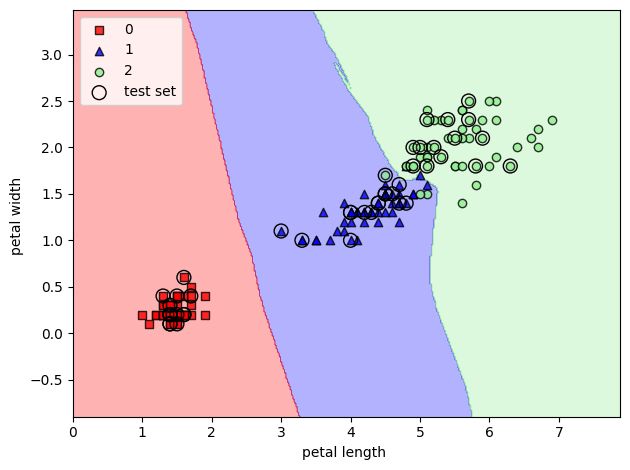

In [16]:
# Use background of graph to represent our predictions
plot_decision_regions(X,y,classifier=my_knn_raw,test_idx=range(105,150))

# Label graph
plt.xlabel('petal length ')
plt.ylabel('petal width ')
plt.legend(loc='upper left')

# Display graph
plt.tight_layout()
plt.show()

**Part 2:** Now train a KNN called my_knn_full on the full, nonstandardized 4D data (the variables we labeled with _full) and check its training and testing results. Plot its decision boundaries using the provided function and compare it to the original KNN we trained (my_knn). Try to explain any differences between the two.

In [21]:
# Prepare KNN with k = 5
my_knn_full = KNeighborsClassifier(n_neighbors=5)

# Fit KNN on standardized training data
my_knn_full.fit(X_full_train, y_train)

# Print training and testing accuracy
print("Training Accuracy:",my_knn_full.score(X_full_train, y_train))
print("Testing Accuracy:",my_knn_full.score(X_full_test, y_test))

# Use this to plot your decision regions:
plot_decision_regions(X_full[:,[2,3]],y,classifier=my_knn_full,test_idx=range(105,150))

# Label graph
plt.xlabel('petal length ')
plt.ylabel('petal width ')
plt.legend(loc='upper left')

# Display graph
plt.tight_layout()
plt.show()

Training Accuracy: 0.9809523809523809
Testing Accuracy: 0.9777777777777777


ValueError: ignored

Overall KNNs are good at showing us the basic idea behind supervised machine learning: we want a model that can *learn* from existing datasets, then *generalize* that knowledge to deal with new data.

## Decision Trees

A much more interesting approach is the use of a **decision tree**. Before we get into its details, let's again check its performance in scikit-learn:

In [22]:
from sklearn.tree import DecisionTreeClassifier

# Set up decision tree with max depth of 4
my_tree = DecisionTreeClassifier(max_depth=4,random_state=1)

# Fit tree on training data
my_tree.fit(X_train_std, y_train)

# Print training and testing accuracies
print("Training Accuracy:",my_tree.score(X_train_std, y_train))
print("Testing Accuracy:",my_tree.score(X_test_std, y_test))

Training Accuracy: 0.9714285714285714
Testing Accuracy: 0.9777777777777777


Ok, not as good as the KNN, but maybe we can see what's happening if we graph it?

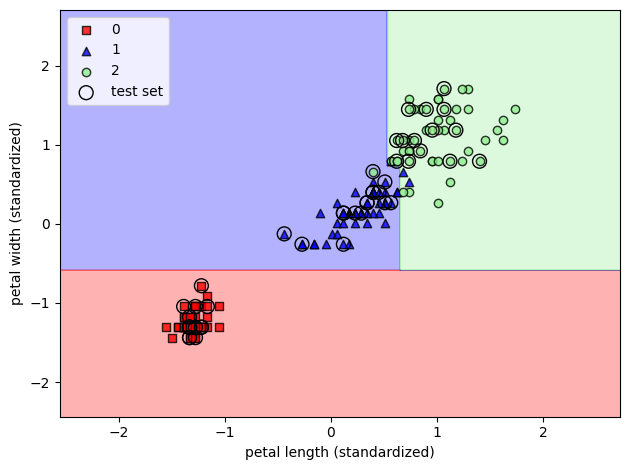

In [23]:
# Use background of graph to represent our predictions
plot_decision_regions(X_std,y,classifier=my_tree,test_idx=range(105,150))

# Label graph
plt.xlabel('petal length (standardized)')
plt.ylabel('petal width (standardized)')
plt.legend(loc='upper left')

# Display graph
plt.tight_layout()
plt.show()

Now the decision boundaries look really straight! But why is this?

As it turns out, decision trees are very special machine learning models due to their ability to easily be visualized. For example, here is what our model looks like:

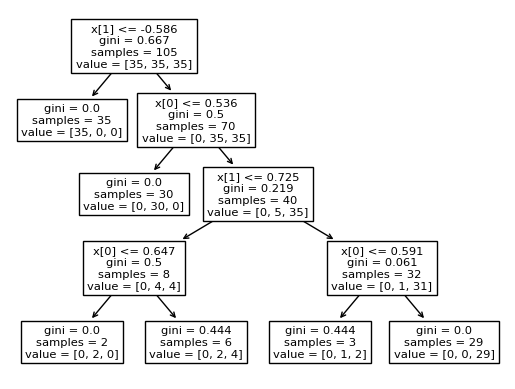

In [24]:
from sklearn import tree

# Map out decision tree
tree.plot_tree(my_tree)
plt.show()

That explains it! This model is making a series of single-dimensional cuts to our data in an effort to minimize some **decision criterion** (in this case, the **Gini Impurity**). Put another way, the model is just one giant nest of if-else statements!

Now, let's play with our model a bit to see the true power of decision trees. First, what happens if we *don't* standardize our test data ahead of time?

Training Accuracy: 0.9714285714285714
Testing Accuracy: 0.9777777777777777


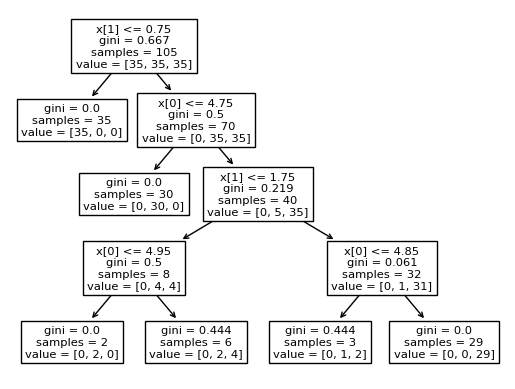

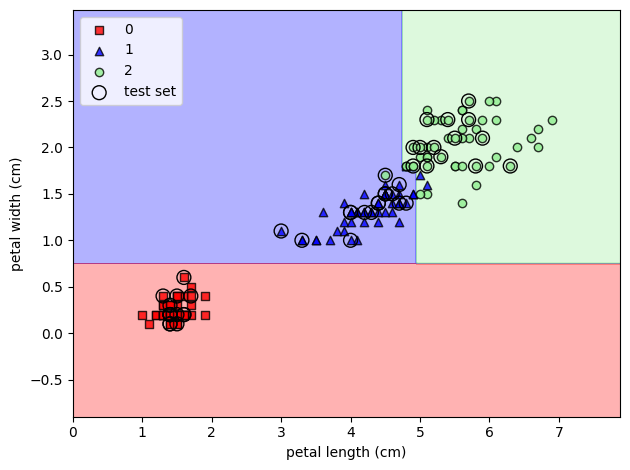

In [25]:
# Set up decision tree with max depth of 4
my_tree = DecisionTreeClassifier(max_depth=4,random_state=1)

# Fit tree on training data
my_tree.fit(X_train, y_train)

# Print training and testing accuracies
print("Training Accuracy:",my_tree.score(X_train, y_train))
print("Testing Accuracy:",my_tree.score(X_test, y_test))

# Map out decision tree
tree.plot_tree(my_tree)
plt.show()

# Use background of graph to represent our predictions
plot_decision_regions(X,y,classifier=my_tree,test_idx=range(105,150))

# Label graph
plt.xlabel('petal length (cm)')
plt.ylabel('petal width (cm)')
plt.legend(loc='upper left')

# Display graph
plt.tight_layout()
plt.show()

Not only is our performance the same, but we can also check exactly how the decision tree works! It seems that our tree first checks if the petal width of a given flower is no more than 0.75 cm. If it is, then that flower is marked as *setosa*; otherwise, the model performs a few more checks to distinguish between the other two species.

This explainability is easily one of best reasons to use a decision tree. It is also very much an anomaly in machine learning. *It is usually best practice (and sometimes a requirement) to scale your data by either standardizing or normalizing it*. But if you're just making a decision tree, don't worry about it!

Next, let's see what happens when we make our decision tree go deeper:

Training Accuracy: 0.9904761904761905
Testing Accuracy: 0.9777777777777777


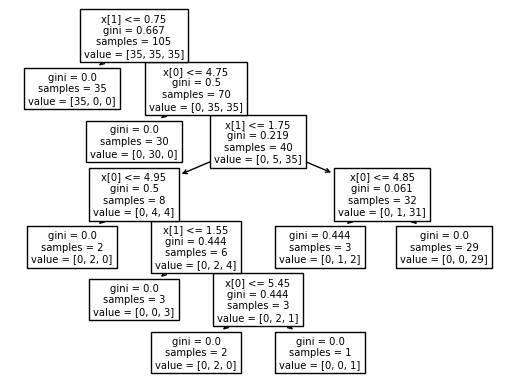

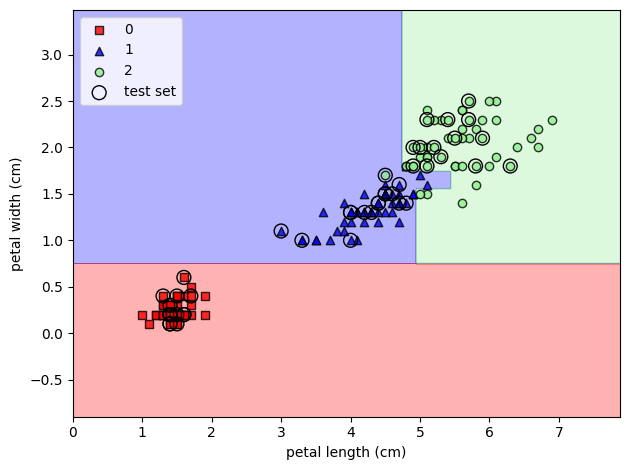

In [26]:
# Set up decision tree with max depth of 8
my_tree = DecisionTreeClassifier(max_depth=8,random_state=1)

# Fit tree on training data
my_tree.fit(X_train, y_train)

# Print training and testing accuracies
print("Training Accuracy:",my_tree.score(X_train, y_train))
print("Testing Accuracy:",my_tree.score(X_test, y_test))

# Map out decision tree
tree.plot_tree(my_tree)
plt.show()

# Use background of graph to represent our predictions
plot_decision_regions(X,y,classifier=my_tree,test_idx=range(105,150))

# Label graph
plt.xlabel('petal length (cm)')
plt.ylabel('petal width (cm)')
plt.legend(loc='upper left')

# Display graph
plt.tight_layout()
plt.show()

First, notice that even though we allowed the tree to have up to eight levels beyond our root node, the tree ended up with just seven. It seems that an eighth level would not help in separating the rest of the data.

But also notice the strange "peninsula" in the blue region, as well as the fact that our testing score did not actually improve. This is an example of **overfitting** since the model is more concerned with optimizing its training performance than finding a general pattern in the data that could be used to analyze new samples. Of course, **underfitting** by using a really small, weak tree can be bad too, as shown here:

Training Accuracy: 0.9523809523809523
Testing Accuracy: 0.9555555555555556


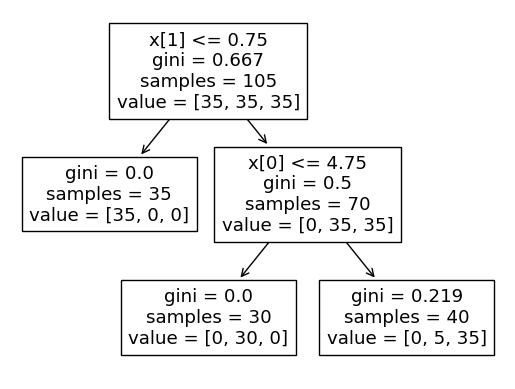

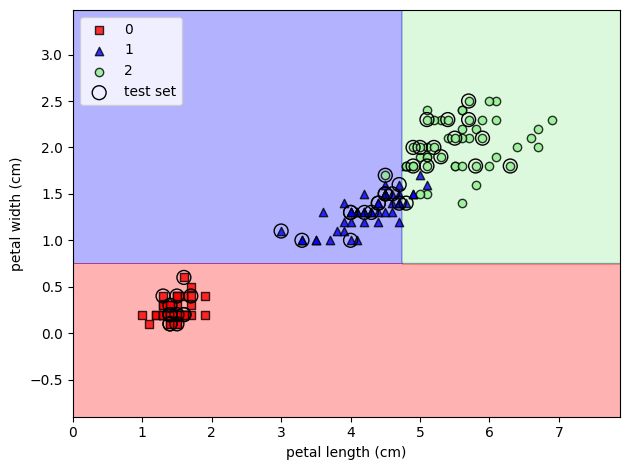

In [27]:
# Set up decision tree with max depth of 2
my_tree = DecisionTreeClassifier(max_depth=2,random_state=1)

# Fit tree on training data
my_tree.fit(X_train, y_train)

# Print training and testing accuracies
print("Training Accuracy:",my_tree.score(X_train, y_train))
print("Testing Accuracy:",my_tree.score(X_test, y_test))

# Map out decision tree
tree.plot_tree(my_tree)
plt.show()

# Use background of graph to represent our predictions
plot_decision_regions(X,y,classifier=my_tree,test_idx=range(105,150))

# Label graph
plt.xlabel('petal length (cm)')
plt.ylabel('petal width (cm)')
plt.legend(loc='upper left')

# Display graph
plt.tight_layout()
plt.show()

Finding a good balance between overfitting and underfitting is one of the fundamental challenges of machine learning.

## Random Forests

So far, we've been dealing with singular models. But it turns out that we can make more powerful predictions by combing several models into an **ensemble**. For example, if we combine several decision trees trained on random parts of the data, we end up with a **random forest**. To decide what class a given point belongs to, we just have each tree cast a "vote" using majority rule. (If there's a tie, the class represented with a lower index wins).

Let's see what happens when we train a forest of seven trees on the Iris dataset:

Training Accuracy: 0.9809523809523809
Testing Accuracy: 0.9777777777777777


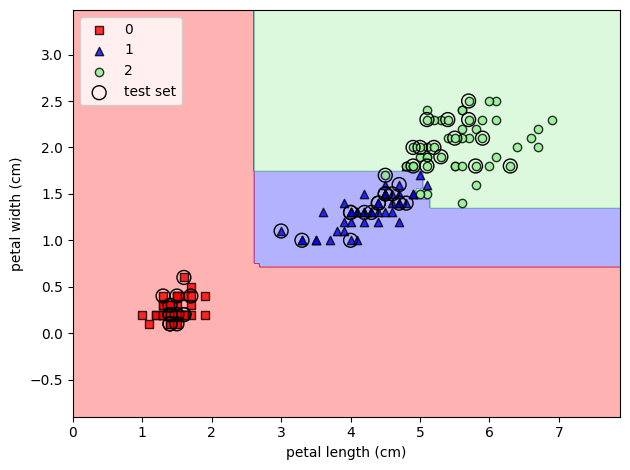

In [28]:
from sklearn.ensemble import RandomForestClassifier

# Set up random forest with four decision trees, each with a max depth of 4
my_forest = RandomForestClassifier(n_estimators=4,max_depth=4,random_state=1) #n_estimator is the number of decision tree
my_forest.fit(X_train, y_train)

# Print training and testing accuracies
print("Training Accuracy:",my_forest.score(X_train, y_train))
print("Testing Accuracy:",my_forest.score(X_test, y_test))

# Use background of graph to represent our predictions
plot_decision_regions(X,y,classifier=my_forest,test_idx=range(105,150))

# Label graph
plt.xlabel('petal length (cm)')
plt.ylabel('petal width (cm)')
plt.legend(loc='upper left')

# Display graph
plt.tight_layout()
plt.show()

Our decision boundaries are now a lot less smooth since we have a bunch of trees arguing over which class each point belongs to. We also are no longer able to get a good visual of our model's "decision process" since our boundaries are now represented by overlapping piecewise functions. But as you'll see in the next exercise, this machine learning classifier makes those sacrifices in order to be more powerful.

### Problem 5.7: Trees Vs Forests

**Part 1**: Train a decision tree called my_tree_full on the full, nonstandardized 4D Iris dataset (using the variables labeled with _full, just like in Exercise 1). Check its training and testing accuracy, then plot its decision regions with the provided function. Can you explain your results?

In [36]:
my_tree_full = DecisionTreeClassifier(max_depth=4,random_state=1)

my_tree_full.fit(X_full_train, y_full_train)

# Print training and testing accuracies
print("Training Accuracy:",my_tree_full.score(X_full_train, y_full_train))
print("Testing Accuracy:",my_tree_full.score(X_full_test, y_full_test))


# Use this to plot your decision regions:
#plot_decision_regions(X_full[:,[2,3]],y,classifier=my_tree_full,test_idx=range(105,150))

# Complete the rest of the graphing by yourself.

Training Accuracy: 0.9714285714285714
Testing Accuracy: 0.9777777777777777


**Part 2:** Now use the plot_tree function to map out your decision tree. Explain step-by-step how your model classifies data points. (Note that the dimensions of the 4D Iris data are organized as follows: sepal length, sepal width, petal length, petal width).

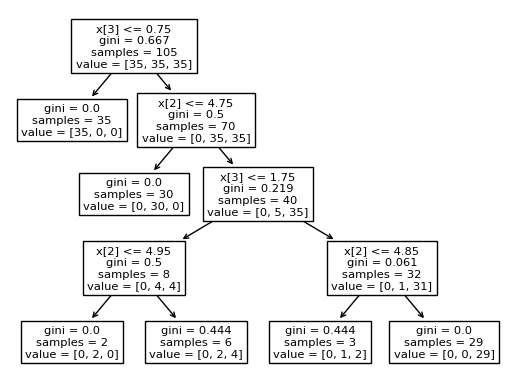

In [37]:
# Map out decision tree
tree.plot_tree(my_tree_full)
plt.show()


**Part 3:** Repeat Part 1 of this exercise with a random forest called my_forest_full. Compare your results to that of the other models we have covered so far.

In [38]:
# Set up random forest with four decision trees, each with a max depth of 4
my_forest_full = RandomForestClassifier(n_estimators=4,max_depth=4,random_state=1) #n_estimator is the number of decision tree
my_forest_full.fit(X_full_train, y_full_train)

# Print training and testing accuracies
print("Training Accuracy:",my_forest_full.score(X_full_train, y_full_train))
print("Testing Accuracy:",my_forest_full.score(X_full_test, y_full_test))


Training Accuracy: 0.9714285714285714
Testing Accuracy: 0.9555555555555556


**Part 4**: The following code will show what the first decision tree in your forest looks like. How is it different from the decision tree in Part 2? Based off of how it looks, can you infer how your random forest classifies data points?

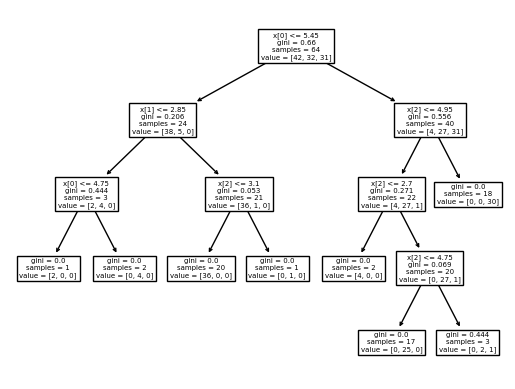

In [39]:
tree.plot_tree(my_forest_full.estimators_[0])
plt.show()

## Perceptrons

The next machine learning model we'll be looking at are **perceptrons**, or artificial neurons. They work by aggregating a bunch of inputs and then "activating" if the sum passes some threshold value. But since there's more than one class in our data, we'll have to take a **One vs Rest (OvR)** approach by creating an ensemble of perceptrons. However, unlike a random forest, each perceptron is trained to distinguish exactly one class, and the model renders its final decision based on which perceptron is most confident in its judgement. This means that, *for this scenario*, the individual perceptrons lack full activation functions.

Let's see how one performs. Note that *we have to go back to using our standardized data.*

In [40]:
from sklearn.linear_model import Perceptron

# Set up standard perceptron
my_ppn = Perceptron(random_state=1)
my_ppn.fit(X_train_std,y_train)

# Print training and testing accuracies
print("Training Accuracy:",my_ppn.score(X_train_std, y_train))
print("Testing Accuracy:",my_ppn.score(X_test_std, y_test))

Training Accuracy: 0.8952380952380953
Testing Accuracy: 0.8888888888888888


What happened with those poor results? We should graph it to find out:

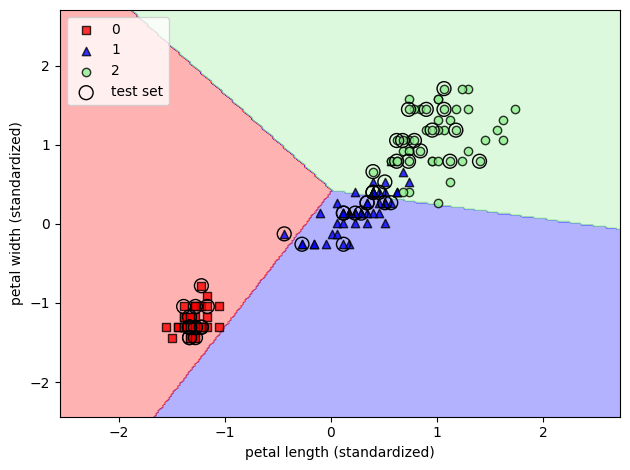

In [41]:
# Plot decision regions
plot_decision_regions(X_std,y,classifier=my_ppn,test_idx=range(105,150))

# Label graph
plt.xlabel('petal length (standardized)')
plt.ylabel('petal width (standardized)')
plt.legend(loc='upper left')

# Display graph
plt.tight_layout()
plt.show()

There's the problem! Perceptrons are **linear models**, so they are useful only for **linearly separable data.** But our data follows a curve that cannot easily be separated out this way. So the perceptron had so much trouble matching the dataset's pattern that it became the first model to misclassify a non-*setosa* flower as a *setosa*!

Thankfully, we can fix this by creating...

## Multilayer Perceptrons (Basic Neural Networks)!

You read that right! By buidling an ordered "chain" of perceptrons with **fully connected layers**, we can boost the power of our model tremendously. This is the basic idea behind most **neural networks**: each node within one is actually just a perceptron. (Neural networks can get a LOT more advanced than this with convolutional layers, adversarial designs and recurrent sections, but that's beyond the reach of this workshop).

One thing to note here: for neural networks to outperform perceptrons, there MUST be at least one layer that uses a non-linear activation function. By default, scikit uses **ReLU (Rectified Linear Unit)**. A perceptron based on this function still activates only once a certain threshold is reached, but instead of just outputting 1, it outputs values from a continous range of linear values. Put another way, it's just a combination of *two* lines, with the left line having a slope of zero and the other having a positive slope.

Let's see what happens if we some fairly standard settings for an MLP. The **hidden** middle layer of the network contains 100 neurons, and the network is allowed to update itself until its error stops changing much or 10000 updates have been made.

In [42]:
from sklearn.neural_network import MLPClassifier

# Set up standard MLP
my_nn = MLPClassifier(max_iter=10000,random_state=1,hidden_layer_sizes=(100,))
my_nn.fit(X_train_std,y_train)

# Print training and testing accuracies
print("Training Accuracy:",my_nn.score(X_train_std, y_train))
print("Testing Accuracy:",my_nn.score(X_test_std, y_test))

Training Accuracy: 0.9523809523809523
Testing Accuracy: 0.9777777777777777


Those scores are still pretty low...but that's not the whole story. As usual, let's graph it:

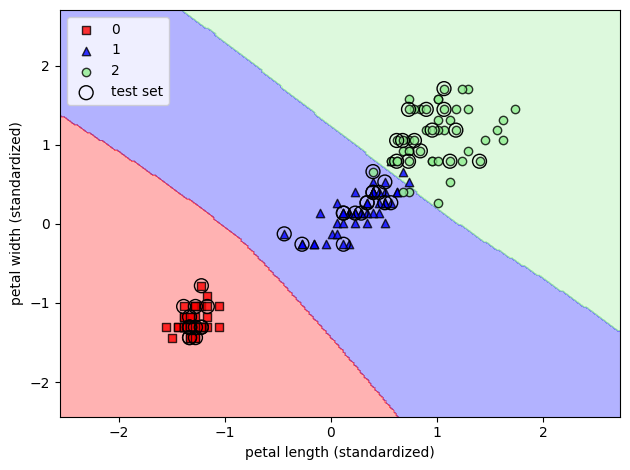

In [43]:
# Plot decision regions
plot_decision_regions(X_std,y,classifier=my_nn,test_idx=range(105,150))

# Label graph
plt.xlabel('petal length (standardized)')
plt.ylabel('petal width (standardized)')
plt.legend(loc='upper left')

# Display graph
plt.tight_layout()
plt.show()

Those decision regions look *amazing*! Instead of worrying about its training error too much, the network seems to have set up diagonal "bands" that try to capture the overall distribution of each class. Neural networks are very popular because of this exact behavior: they can learn advanced, underlying patterns in data that most other machine learning classifiers would miss. Since neural networks can get very large, it can be hard to determine *what* these patterns are sometimes, but on enormous datasets the power of neural networks is nearly unrivaled.

### Problem 5.8: The Power of Deep Learning

This is a pretty freeform exercise. Like Exercises 1 and 2, your goal here is to apply a multilayer perceptron called my_nn_full to the full 4D Iris dataset. Remember that you need to use the *standardized* version!

However, you are allowed to experiment with your neural network as much as you like in order to optimize your training and testing accuracy. Here's a link to the scikit-learn documentation for help: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

To help with this, I strongly recommend setting the verbose argument to true. This will let you witness your neural network's training in real time. If your network's performance changes wildly from trial to trial, it means you need to optimize it more!

If you're still lost, I suggest starting with the hidden_layer_sizes. For instance, a neural network with 2 hidden layers with 10 neurons each would have hidden_layer_sizes=(10,10,).

In [70]:
# YOUR CODE HERE
from sklearn.neural_network import MLPClassifier

# Set up standard MLP
my_nn_full = MLPClassifier(max_iter=10000,random_state=200,hidden_layer_sizes=(100,100,100,100))
my_nn_full.fit(X_full_train_std,y_full_train)

# Print training and testing accuracies
print("Training Accuracy:",my_nn_full.score(X_full_train_std, y_full_train))
print("Testing Accuracy:",my_nn_full.score(X_full_test_std, y_full_test))

Training Accuracy: 1.0
Testing Accuracy: 0.9333333333333333


# Regression

## Introduction

So far we've been dealing only with **classification** problems, which focus on predicting **discrete** data (classes). But if we want to predict **continuous** data instead, then we have to use **regression** models.

As it turns out, each model that we've covered so far EXCEPT for the basic perceptron has a regression equivalent in scikit-learn. As an example, let's use scikit-learn to make a toy regression dataset.

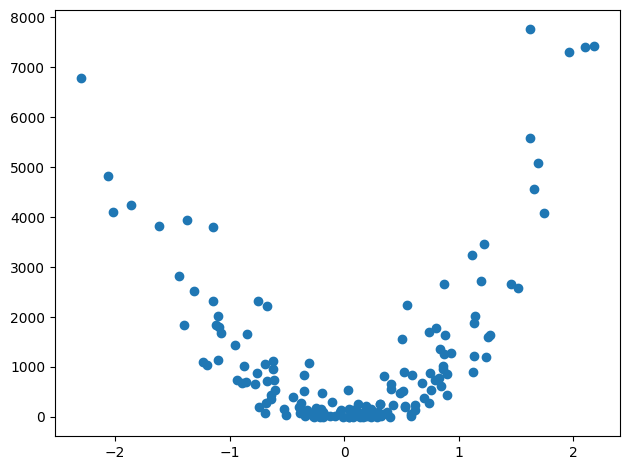

In [72]:
from sklearn.datasets import make_regression

# Create noisy linear data but square outputs
X, y = make_regression(n_features=1,n_samples=150,noise=10,random_state=1)
y = y**2

# Plot the data
plt.scatter(X,y)
plt.tight_layout()
plt.show()

This is an obviously quadratic dataset, just with some noise applied. So attempting generic linear regression won't work too well:

In [73]:
from sklearn.linear_model import LinearRegression

# Run linear regression algorithm on data
my_linreg = LinearRegression().fit(X,y)

# Print R^2 of model
print(my_linreg.score(X,y))

0.02411005851115866


This time, the score is the R^2 value for the model's predictions. It means that our model is so bad, it explains less than 2.5% of the variance in the data.

I'll now use another function from the textbook I mentioned earlier to help visualize what's happening.

In [74]:
# Taken directly from Python Machine Learning 3rd Edition
def lin_regplot(X,y,model):
  sort_idx = X.flatten().argsort()
  plt.scatter(X,y,c='blue',edgecolor='white',s=70)
  plt.plot(X[sort_idx], model.predict(X[sort_idx]),color='black',lw=2)
  return None

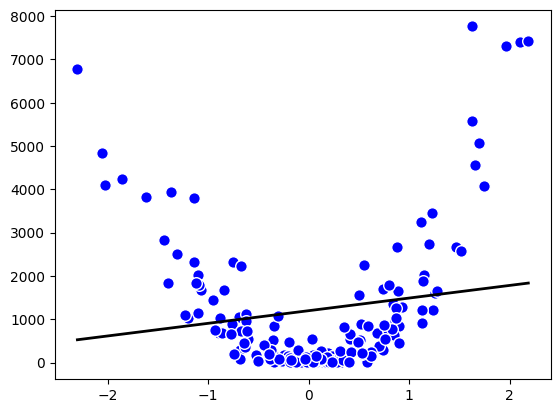

In [75]:
# Plot model's predictions (in black) against actual data (in blue)
lin_regplot(X,y,my_linreg)
plt.show()

That line isn't even close to representing the patterns in our data. Let's see how a decision tree performs instead:

In [76]:
from sklearn.tree import DecisionTreeRegressor

# Fit decision tree on data
my_tree = DecisionTreeRegressor(max_depth=4, random_state=1)
my_tree.fit(X,y)

# Check R^2 of model
print(my_tree.score(X,y))

0.885636039078498


It looks like the model is performing somewhat well based on this value (it explains 88.5% of the variance in the data). Let's plot it:

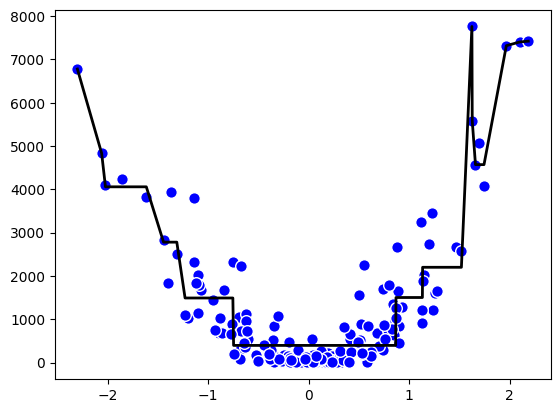

In [77]:
# Plot model's predictions (in black) against actual data (in blue)
lin_regplot(X,y,my_tree)
plt.show()

Don't worry, the diagonal lines just come from the visualizer approximating the tree's decision function. The actual decision function is still just a piecewise function of horizontal and vertical lines, as shown here:

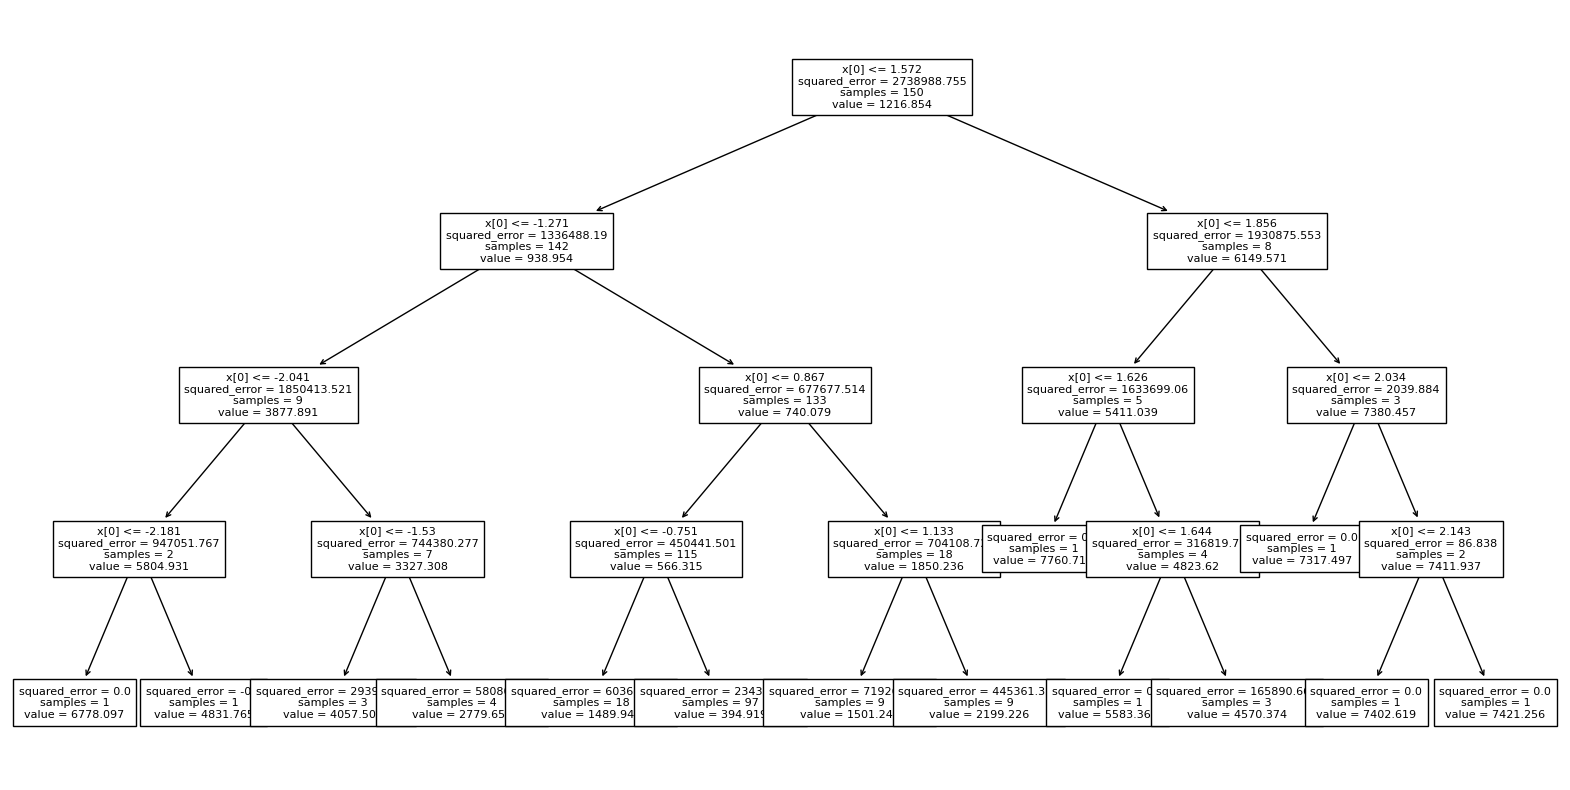

In [78]:
# Size up cell output to fit the image we're about to make
plt.figure(figsize=(20,10))

# Map and display the decision tree
tree.plot_tree(my_tree,fontsize=8) # First tree in forest
plt.show()

So decision trees *can* be used to analyze non-linear datasets, but they won't give smooth outputs. This is actually true for *most* machine learning models, though a well made neural network can sometimes avoid it.

But as you can see, regression in sklearn is pretty similar to classification! You just have to rename a few things.

# **QUIZ**: Comparing Machine Learning Models

Part 1: Say I had a huge dataset with lots of complicated patterns. What type of machine learning should I use?

Part 2: If I need to make a machine learning model with decision boundaries I can easily visualize and explain, what type of machine learning should I use?

Part 3: Now say I am dealing with data that I know involves lots of tight, uniclass clusters. What machine learning model would perform best?

# Appendix/Bonus Examples

## Decision Criterions

Let's experiment with different **decision criterions**. The **Gini impurity** measure we've been using has a somewhat complicated formula, but if you've taken a thermodynamics course you'll probably be familiar with **entropy** as a replacement. Let's try it!

Training Score: 0.9523809523809523
Testing Score: 0.9333333333333333


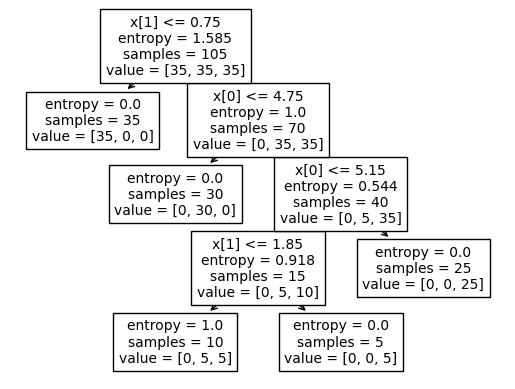

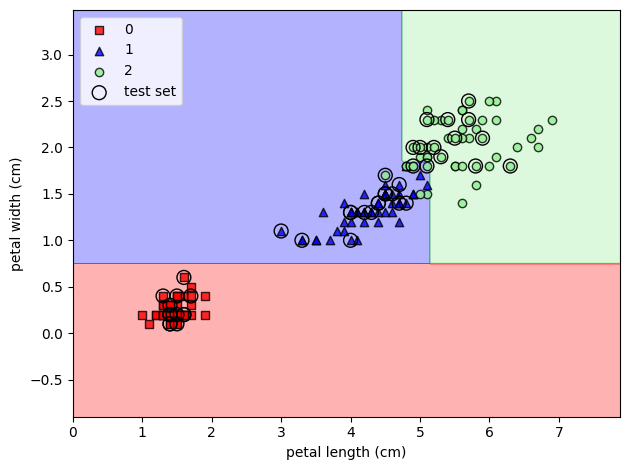

In [ ]:
# NOTE: restart the runtime and run every cell before the Classification section before trying this code.
my_tree = DecisionTreeClassifier(criterion='entropy',max_depth=4,random_state=1)
my_tree.fit(X_train, y_train)
print("Training Score:",my_tree.score(X_train, y_train))
print("Testing Score:",my_tree.score(X_test, y_test))

tree.plot_tree(my_tree)
plt.show()

plot_decision_regions(X,y,classifier=my_tree,test_idx=range(105,150))
plt.xlabel('petal length (cm)')
plt.ylabel('petal width (cm)')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

The decision region looks very similar to how it did earlier, but our accuracies are much worse. That might imply that Gini impurity is "better" than entropy as a decision criterion, but that's for this case only. In reality, these two criterions are really similar, so its worth experimenting with them whenever you need to make a decision tree. There is also a third, more unique criterion called **log-loss** that you can try as well.

In [79]:
from sklearn.ensemble import AdaBoostClassifier

my_ada = AdaBoostClassifier()
my_ada.fit(X_train, y_train)

AdaBoostClassifier()